## Import libraries and load dataset

In [2093]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2094]:
df = pd.read_csv('tmp_alb_tx_sums_202004021132.csv')
df.site_version.astype('category')
df= df[df['site_version']== '0000']
#check the decoration
df.columns

Index(['atoll_schema', 'site_version', 'site_name', 'fuze_site_id',
       'site_record_id', 'latitude_degrees', 'longitude_degrees',
       'street_address', 'city', 'county', 'state', 'zip_code', 'sector',
       'azimuth', 'antenna_model', 'antenna_manufacturer', 'antenna_max_gain',
       'antenna_centerline', 'lte_market', 'enodeb_id', 'max_power',
       'main_propagation_model', 'radio_manufacturer', 'radio_model',
       'extended_calculation_radius', 'enodeb_eutrancellfdd', 'channel_number',
       'pci', 'antenna_h_bw', 'mechanical_tilt', 'electrical_tilt', 'ret',
       'altitude_amsl', 'tac', 'cell_id', 'technology', 'band_class',
       'trans_cell_type', 'site_record_name', 'site_number', 'site_code',
       'location_name', 'fips_county_code', 'search_ring_id',
       'peoplesoft_location_code', 'site_on_air_date', 'c_ran_hub_name',
       'address_description', 'network_territory', 'network_market',
       'network_sub_market', 'network_local_market', 'site_altitude_ams

### First things first: analysing 'Sum'

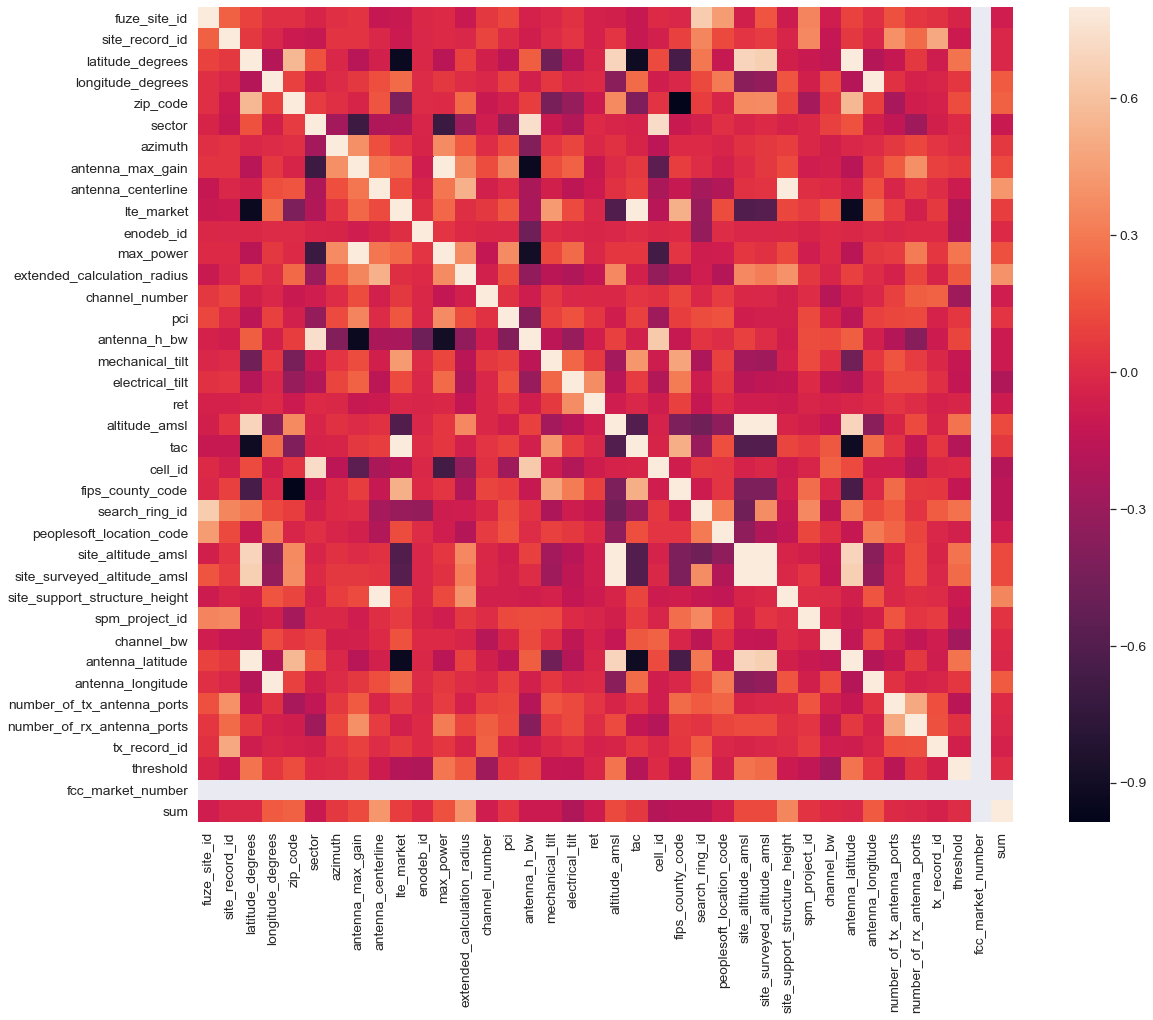

In [2095]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.8, square=True);

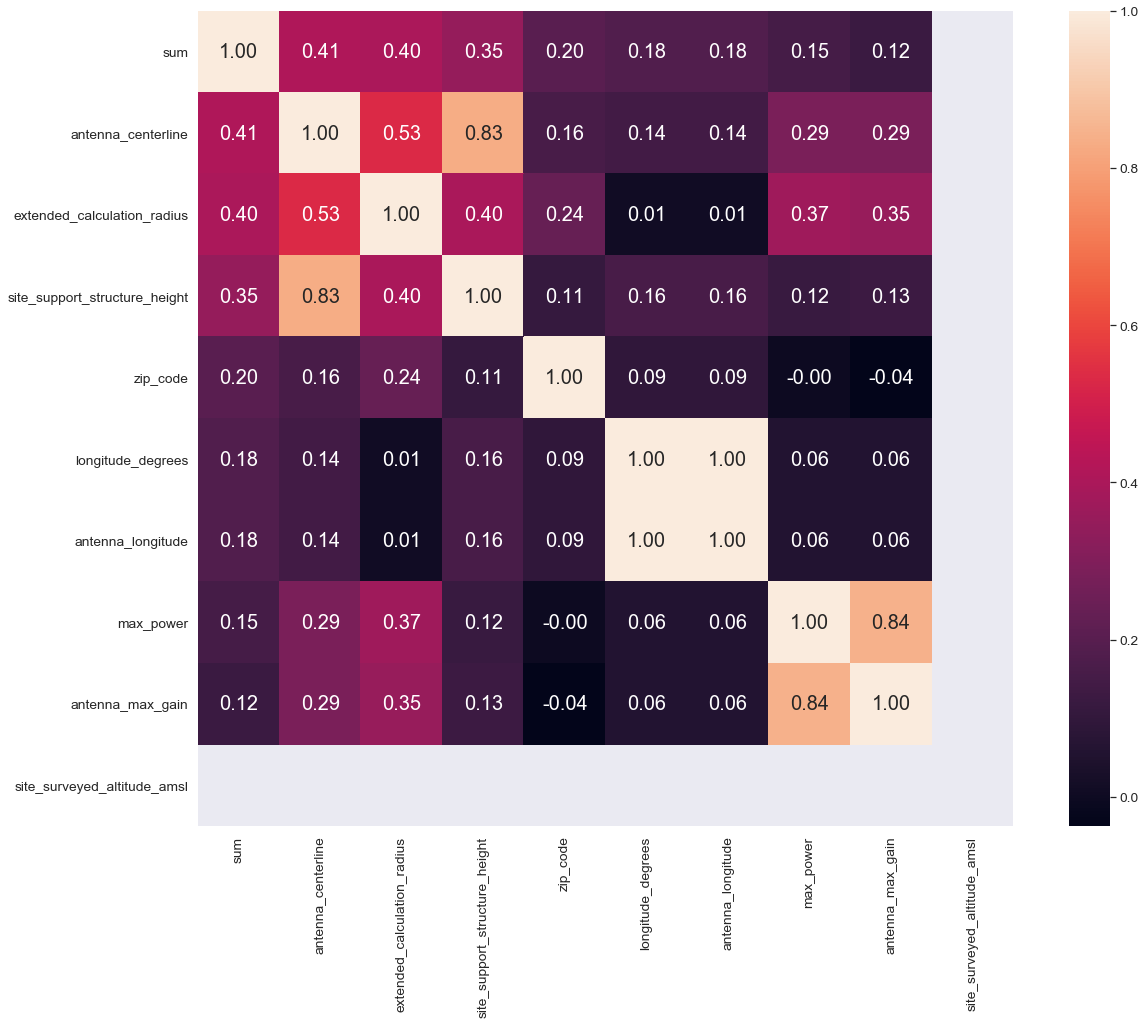

In [2096]:
#sum correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sum')['sum'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(20, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### We see that 'antenna_centerline','extended_calculation_radius', 'site_support_structure_height' are somewhat correlated with the'Sum'

In [2098]:
df['sum'].describe()

count    5.137000e+03
mean     5.685331e+08
std      1.227489e+09
min      9.001435e+02
25%      3.005578e+07
50%      1.627407e+08
75%      5.791687e+08
max      2.926708e+10
Name: sum, dtype: float64

## Missing Data

In [2099]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent*100], axis=1, keys=['Total Missing Count', 'Percent'])
missing_data[missing_data['Total Missing Count'] !=0]

,Total Missing Count,Percent
fcc_market_number,5137,100.000000
c_ran_hub_name,5012,97.566673
site_on_air_date,4716,91.804555
site_structure_type,4696,91.415223
search_ring_id,4659,90.694958
threshold,4647,90.461359
coverage_type,4647,90.461359
duplex_type,4647,90.461359
xmtr_location,4647,90.461359
address_description,4470,87.015768


Text(0.5, 1.0, 'Percent missing data by feature')

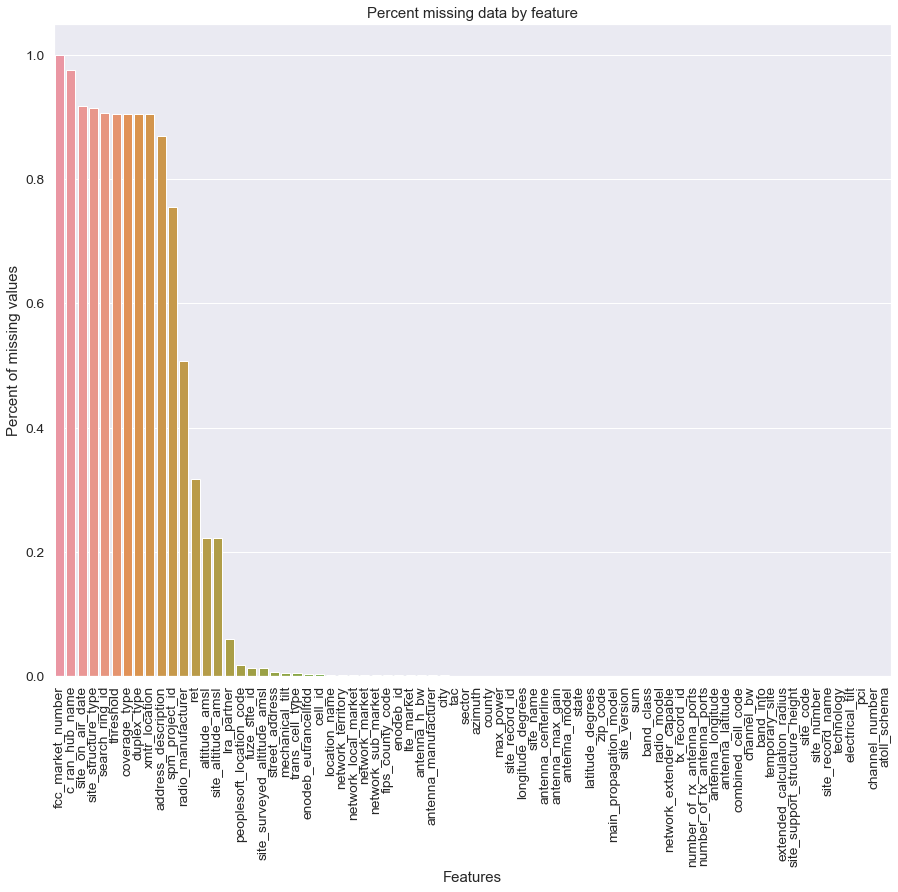

In [2100]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=percent.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [2101]:
#dealing with missing data
df = df.drop((missing_data[missing_data['Total Missing Count'] > 1000]).index,1)

In [2102]:
#function to treat missing values
def fill_na_with_mean_or_mode(col):
    if col.dtype == int or col.dtype == float:
        return col.fillna(round(col.median()), inplace=True)
    else:
        return col.fillna(col.mode()[0], inplace=True)

In [2103]:
#passed my function through a list comprehension so i could fill all null columns with one line of code
[fill_na_with_mean_or_mode(df[col]) for col in ['lra_partner','peoplesoft_location_code','fuze_site_id','site_surveyed_altitude_amsl',
                                                'street_address','trans_cell_type','mechanical_tilt','enodeb_eutrancellfdd','cell_id',
                                               'location_name','network_market','fips_county_code','network_territory','network_local_market',
                                               'network_sub_market','lte_market','enodeb_id','antenna_h_bw','antenna_manufacturer','tac',
                                               'city','sector','max_power','channel_bw','band_class','channel_number','pci']];
df.isnull().sum().max()

0

### In summary, to handle missing data, we deleted all the variables with missing data >1000 and for remaining we replaced with median/mode values

## Outliers

In [2104]:
# deleting data points which are outliers
#df.sort_values(by = 'sum', ascending = False)[:2]
df = df.drop(df[df['fuze_site_id'] == 480809.0].index)
#df.sort_values(by = 'site_support_structure_height', ascending = False)[:3]
df = df.drop(df[df['fuze_site_id'] == 355319.0].index)

### The max value with highest 'sum' seem strange and they are not following the crowd. We can speculate why this is happening.Therefore, we'll define them as outliers and delete them.

In [2105]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])

Rows     :  5128
Columns  :  59


In [2106]:
df.select_dtypes(object).columns

Index(['atoll_schema', 'site_version', 'site_name', 'street_address', 'city',
       'county', 'state', 'antenna_model', 'antenna_manufacturer',
       'main_propagation_model', 'radio_model', 'enodeb_eutrancellfdd',
       'technology', 'band_class', 'trans_cell_type', 'site_record_name',
       'site_number', 'site_code', 'location_name', 'network_territory',
       'network_market', 'network_sub_market', 'network_local_market',
       'temporary_site', 'lra_partner', 'network_extender_capable',
       'band_info', 'combined_cell_code'],
      dtype='object')

In [2108]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder


categorical_columns=['county', 'antenna_model',
       'main_propagation_model', 'radio_model',  'band_class', 'trans_cell_type', 'network_extender_capable',
       'band_info']
column_trans = make_column_transformer((OrdinalEncoder(), categorical_columns))
df_transformed=column_trans.fit_transform(df)

In [2109]:
df_trans = pd.DataFrame(df_transformed,columns=categorical_columns)
#converting to integer datatype
df_trans=df_trans.astype(int)
df_trans

,county,antenna_model,main_propagation_model,radio_model,band_class,trans_cell_type,network_extender_capable,band_info
0,30,941,5,79,2,2,1,15
1,7,217,16,91,1,2,1,0
2,33,938,4,98,1,2,1,0
3,2,669,21,4,2,2,1,16
4,33,938,4,98,1,2,1,0
...,...,...,...,...,...,...,...,...
5123,29,120,5,46,2,2,1,17
5124,29,120,5,46,2,2,1,17
5125,15,448,3,98,5,2,1,2
5126,15,448,3,98,5,2,1,2


In [2111]:
df=df.reset_index()
df.update(df_trans)

In [2113]:
#considering only important and corelated features
df=df[['azimuth', 'antenna_model', 'antenna_max_gain',
       'antenna_centerline', 'max_power',
       'main_propagation_model', 'extended_calculation_radius',
        'pci', 'antenna_h_bw',
       'mechanical_tilt', 'electrical_tilt', 'tac',  
       'site_surveyed_altitude_amsl', 'site_support_structure_height',
        'channel_bw', 'sum']]

In [2114]:
df

,azimuth,antenna_model,antenna_max_gain,antenna_centerline,max_power,main_propagation_model,extended_calculation_radius,pci,antenna_h_bw,mechanical_tilt,electrical_tilt,tac,site_surveyed_altitude_amsl,site_support_structure_height,channel_bw,sum
0,240,941,15.562,37.0,49.542425,5,99.999751,287.0,81.75,0.0,0.0,6404.0,7177.6,41.000001,15.0,8.263681e+08
1,240,217,13.300,38.0,47.781513,16,29.999801,165.0,71.00,5.0,9.0,6658.0,4189.0,45.011525,10.0,2.184412e+08
2,45,938,13.540,120.0,46.000000,4,99.999751,285.0,79.75,7.0,8.0,6403.0,5439.0,231.059161,10.0,1.614895e+08
3,120,669,16.000,100.0,47.781513,21,29.999801,202.0,81.00,6.0,0.0,6660.0,3623.5,197.050453,20.0,2.872214e+08
4,165,938,13.540,120.0,46.000000,4,99.999751,286.0,79.75,5.0,8.0,6403.0,5439.0,231.059161,10.0,1.407915e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5123,230,120,15.600,88.0,47.781513,5,99.999751,109.0,82.75,0.0,0.0,6403.0,4601.5,90.023050,20.0,2.454942e+08
5124,350,120,15.600,88.0,47.781513,5,99.999751,110.0,82.75,0.0,0.0,6403.0,4601.5,90.023050,20.0,3.250458e+08
5125,30,448,15.590,168.0,47.781513,3,99.999751,3.0,64.00,0.0,4.0,6658.0,6575.5,180.000006,10.0,2.962542e+07
5126,240,448,15.590,168.0,47.781513,3,99.999751,4.0,64.00,0.0,4.0,6658.0,6575.5,180.000006,10.0,1.680068e+07


### Separating Features and Labels

In [2115]:
# Labels are the values we want to predict
labels = np.array(df['sum'])
# Remove the labels from the features
# axis 1 refers to the columns
features= df.drop('sum', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [2116]:
features

array([[ 0.86017932,  1.34615677,  0.48178166, ...,  1.57834637,
        -0.84085252,  0.97575644],
       [ 0.86017932, -1.1960176 ,  0.04001192, ..., -0.66213864,
        -0.79281804, -0.29582654],
       [-0.88775229,  1.3356229 ,  0.08688405, ...,  0.27495775,
         1.43493939, -0.29582654],
       ...,
       [-1.02220857, -0.38490948,  0.48725008, ...,  1.12696578,
         0.82355075, -0.29582654],
       [ 0.86017932, -0.38490948,  0.48725008, ...,  1.12696578,
         0.82355075, -0.29582654],
       [ 1.57727947, -0.38490948,  0.48725008, ...,  1.12696578,
         0.82355075, -0.29582654]])

### Split Train and Test Data using Sklearn

In [2117]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4102, 15)
Training Labels Shape: (4102,)
Testing Features Shape: (1026, 15)
Testing Labels Shape: (1026,)


### Model - Random Forest Regressor

In [2199]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with default parameters
rf = RandomForestRegressor(random_state=42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [2200]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [2201]:
predictions

array([7.12789379e+07, 3.02264400e+06, 2.30803833e+09, ...,
       1.03639080e+09, 5.60631934e+08, 2.09161293e+08])

In [2202]:
test_labels

array([6.50069998e+08, 4.15519452e+06, 1.53194203e+09, ...,
       1.20549800e+09, 8.69101930e+08, 2.73293775e+08])

In [2203]:
from sklearn.metrics import r2_score,mean_squared_error
r2_score(test_labels, predictions)

0.7179823563576935

In [2204]:
mse=mean_squared_error(test_labels, predictions)
rmse= np.sqrt(mse)
rmse

569072212.0037285

### Applying GridSearchCV and RandomSearchCV to find best parameters

#### GridSearchCV

In [1038]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor()
param_grid = { 
    'n_estimators': [200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(features, labels)
print(CV_rfc.best_params_)

{'max_features': 'sqrt', 'n_estimators': 500}


#### RandomSearchCV

In [1044]:
#RandomSearchCV
rfc = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": ['auto', 'sqrt', 'log2'],
              "n_estimators": [200,500]}
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                   n_iter=3, cv=5, iid=False, random_state=42)
random_search.fit(features, labels)
print(random_search.best_params_)

{'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': None}


### Applying model with best parameters

In [2205]:
regressor = RandomForestRegressor(max_features= 'sqrt',n_estimators = 500,random_state=42)
# Train the model on training data
regressor.fit(train_features, train_labels)
predictions1 = regressor.predict(test_features)

### Prediction on test set

In [2206]:
predictions1

array([1.58217123e+08, 3.01136749e+06, 2.00418240e+09, ...,
       9.52326314e+08, 5.19620977e+08, 2.33612779e+08])

In [2207]:
test_labels

array([6.50069998e+08, 4.15519452e+06, 1.53194203e+09, ...,
       1.20549800e+09, 8.69101930e+08, 2.73293775e+08])

### Root Mean Squared Error (RMSE)

In [2208]:
mse=mean_squared_error(test_labels, predictions1)
rmse= np.sqrt(mse)
print('The root mean squared error is ',rmse)

The root mean squared error is  611134347.6217017


### R-Squared Value

In [2209]:
from sklearn.metrics import r2_score,mean_squared_error
r2_score(test_labels, predictions1)

0.6747517960640356

#### R-squared value 65% indicates that the model explains 65 percent variability of the response data around its mean (how close the data are to the fitted regression line)

In [162]:
actualvspredicted= pd.DataFrame({'Actual': test_labels,'Predicted': predictions1})
actualvspredicted.to_csv('Test_predictions.csv')
actualvspredicted

,Actual,Predicted
0,6.500700e+08,4.063442e+08
1,4.155195e+06,3.064378e+06
2,1.531942e+09,1.973429e+09
3,1.944061e+08,2.099434e+08
4,8.878759e+08,8.488751e+08
...,...,...
1021,2.317214e+09,2.331877e+09
1022,1.830249e+07,6.853226e+07
1023,1.205498e+09,9.171071e+08
1024,8.691019e+08,4.251460e+08


## TPOTRegressor 
### Use TPOT regressor to find the best model algorithm that fits the data. TPOT uses genetic algorithm based search internally

### Run the TPOT optimization process on the given training data.

In [2212]:
#Import TPOT 
import timeit
from tpot import TPOTRegressor
# instantiate tpot 
tpot = TPOTRegressor(generations=50, population_size=30,scoring='r2', verbosity=2)
tpot.fit(train_features, train_labels)


Generation 1 - Current best internal CV score: 0.5959416235848238
Generation 2 - Current best internal CV score: 0.5959416235848238
Generation 3 - Current best internal CV score: 0.6001268443712438
Generation 4 - Current best internal CV score: 0.6917800890915017
Generation 5 - Current best internal CV score: 0.6917800890915017
Generation 6 - Current best internal CV score: 0.6917800890915017
Generation 7 - Current best internal CV score: 0.6917800890915017
Generation 8 - Current best internal CV score: 0.6917800890915017
Generation 9 - Current best internal CV score: 0.6917800890915017
Generation 10 - Current best internal CV score: 0.6917800890915017
Generation 11 - Current best internal CV score: 0.6917800890915017
Generation 12 - Current best internal CV score: 0.6917800890915017
Generation 13 - Current best internal CV score: 0.6917800890915017
Generation 14 - Current best internal CV score: 0.6917800890915017
Generation 15 - Current best internal CV score: 0.6917800890915017
Gene

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=50,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=30,
              random_state=None, scoring='r2', subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [2213]:
print(tpot.score(test_features, test_labels))

0.7599653373236183


#### R-squared value 76% indicates that the model explains 76 percent variability of the response data around its mean (how close the data are to the fitted regression line)

### Use the optimized pipeline to predict the target values for a feature set

In [2214]:
predictions_tpot=tpot.predict(test_features)
predictions_tpot

array([1.6922890e+08, 4.2335440e+06, 1.9179505e+09, ..., 9.8208166e+08,
       5.8437414e+08, 2.4868586e+08], dtype=float32)

In [2226]:
actualvspredicted= pd.DataFrame({'Actual Sum': test_labels,'Predicted Sum': predictions_tpot})
actualvspredicted.to_csv('Test_predictions_TPOT.csv')
actualvspredicted

,Actual Sum,Predicted Sum
0,6.500700e+08,1.692289e+08
1,4.155195e+06,4.233544e+06
2,1.531942e+09,1.917950e+09
3,1.944061e+08,1.517202e+08
4,8.878759e+08,9.486225e+08
...,...,...
1021,2.317214e+09,1.580821e+09
1022,1.830249e+07,7.929344e+07
1023,1.205498e+09,9.820817e+08
1024,8.691019e+08,5.843741e+08


### Export the scikit learn code for best regressor and dispay the code

In [513]:
tpot.export('tpot_cell_analysis.py')